In [1]:
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from torchvision import models, transforms
from PIL import Image

In [4]:
!pip install torch
!pip install transforms
!pip install torchvision

In [2]:
path = r"/workspace/Documents"
path_paintings = r"/workspace/Documents/data"

In [90]:
url = "https://raw.githubusercontent.com/thefth/ArtSAGENet/main/Dataset/wikiart_artists.csv"
data_test = pd.read_csv(url)

data_test = data_test[data_test['mode'] == 'test']

data_test = data_test.reset_index(drop = True)

In [91]:
data_test = pd.read_csv("semantic_data_test.csv", index_col=0)

In [5]:
#initial dataset of paitings information

data = pd.read_csv("semantic_data.csv", index_col=0)

In [6]:
#initial representations od each node onstructed from semantic data and visual features

features = pd.read_csv(path + r"/node_representations.csv", index_col=0)

features_test = pd.read_csv("node_representations_test.csv", index_col = 0)

In [7]:
#knowledge graph where nodes representimg ine artists school are adjacent

knowledge_graph = torch.load("adjacency_school.t")

knowledge_graph_test = torch.load('adjacency_school_test.t')

In [8]:
if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'
device = torch.device(dev)

In [9]:
device_cpu = torch.device('cpu')

## Graph representation learning

### Visual features

In [363]:
transform = transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                   std=[0.229, 0.224, 0.225])])

In [364]:
resnet34 = models.resnet34(pretrained = True)
resnet34.eval();

In [365]:
newmodel = torch.nn.Sequential(*(list(resnet34.children())[:-1]))

In [361]:
for param in newmodel.parameters():
    param.requires_grad_(False)

In [372]:
img = Image.open(path_paintings + r"/" + tagFeatures_test.index[0])
transformed_img = transform(img)
transformed_img = torch.unsqueeze(transformed_img, 0)

In [374]:
visual_features = torch.flatten(newmodel(transformed_img), start_dim = 2)[0]

In [383]:
failed = []
for i in tqdm(tagFeatures_test.index[4:]):
    try:
        img = Image.open(path_paintings + r"/" + i)
        transformed_img = transform(img)
        transformed_img = torch.unsqueeze(transformed_img, 0)

        visual_features=torch.cat([visual_features, torch.flatten(newmodel(transformed_img), start_dim = 2)[0]], 1)
    except:
        failed.append(i)

100%|██████████| 947/947 [02:27<00:00,  6.41it/s]


###  Bag-of-words tag feature vectors

In [268]:
from collections import Counter

In [342]:
data_test['tags'] = data_test['tags'].fillna('Unknown')

In [343]:
#get all tags from dataset and select labels that appear >= 10 times
all_tags = []
for lst in data_test['tags'].map(lambda x: x.split(",")).values:
    all_tags += lst
    
c = Counter(all_tags)

In [349]:
labels_to_use = []
for key in c:
    if key in tagFeatures.columns:
        labels_to_use.append(key)

In [350]:
#
#
# table with bag of words tag feature vectors
#
#

features_test = pd.DataFrame(data = 0, index = data_test.index, columns = tagFeatures.columns)

In [351]:
for ind in data_test.index:
    labels_of_painting = list(set(labels_to_use) & set(data_test.loc[ind]['tags'].split(",")))
    features_test.loc[ind][labels_of_painting] = 1

In [371]:
tagFeatures_test.index = data_test['relative_path']

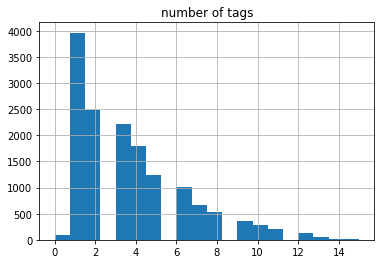

In [370]:
#histogram of number of tags of each painting
tagFeatures.sum(axis = 1).hist(bins = 20)
plt.title("number of tags")
plt.show()

In [325]:
tagFeatures = pd.read_csv(path + r"/featureTags.csv", index_col = 0)

In [39]:
tagFeatures.index = data['relative_path'] 

### Constructing initial node representation

In [405]:
representations_test = torch.cat([torch.FloatTensor(tagFeatures_test.values).t(), visual_features]).t()

In [414]:
features_test = pd.DataFrame(representations_test.detach().numpy(), index = data_test['relative_path'])

In [743]:
#
# Get node representations
#
for ind in tqdm(data.index[465:]):
    try:
        img = Image.open(path_paintings + r"/" + data.loc[ind]['relative_path'])
        transformed_img = transform(img)
        batch_t = torch.unsqueeze(transformed_img, 0)

        visual_part = torch.flatten(newmodel(batch_t), start_dim = 1)[0].detach().numpy()
        semantic_part = tagFeatures.loc[ind]

        representation = np.concatenate([visual_part, semantic_part.values])

        representations.loc[ind] = representation   
    
    except:
        pass




  0%|          | 0/14606 [00:00<?, ?it/s]

  1%|          | 161/14606 [00:00<00:09, 1601.86it/s]

  2%|▏         | 365/14606 [00:00<00:08, 1711.37it/s]

  4%|▍         | 577/14606 [00:00<00:07, 1815.60it/s]

  5%|▌         | 788/14606 [00:00<00:07, 1893.44it/s]

  7%|▋         | 999/14606 [00:00<00:06, 1952.39it/s]

  8%|▊         | 1210/14606 [00:00<00:06, 1996.42it/s]

 10%|▉         | 1421/14606 [00:00<00:06, 2028.61it/s]

 11%|█         | 1632/14606 [00:00<00:06, 2051.80it/s]

 13%|█▎        | 1844/14606 [00:00<00:06, 2070.34it/s]

 14%|█▍        | 2054/14606 [00:01<00:06, 2078.03it/s]

 16%|█▌        | 2265/14606 [00:01<00:05, 2087.05it/s]

 17%|█▋        | 2477/14606 [00:01<00:05, 2094.54it/s]

 18%|█▊        | 2688/14606 [00:01<00:05, 2098.06it/s]

 20%|█▉        | 2900/14606 [00:01<00:05, 2102.64it/s]

 21%|██▏       | 3111/14606 [00:01<00:05, 2104.38it/s]

 23%|██▎       | 3323/14606 [00:01<00:05, 2106.97it/s]

 24%|██▍       | 3534/14606 [00:01<00:05, 2107.09it/s]

 26%|██▌

### Constructing adjacency matrices

In [418]:
rows = []
columns = []
for school in tqdm(data_test['artist_school'].unique()): 
    pairs = combinations(data_test[data_test['artist_school'] == school].index, 2)
    for i, j in pairs:
        rows.append(i)
        columns.append(j)

100%|██████████| 11/11 [00:00<00:00, 230.16it/s]


In [18]:
# torch
school_adj = torch.sparse_coo_tensor([rows, columns], np.ones(len(rows)), (len(data), len(data)))
school_adj = torch.t(school_adj) + school_adj

In [419]:
# torch
school_adj_test = torch.sparse_coo_tensor([rows, columns], np.ones(len(rows)), (len(data_test), len(data_test)))
school_adj_test = torch.t(school_adj_test) + school_adj_test

In [104]:
# scipy
school_adj = sparse.csr_matrix((np.ones(len(rows)), (rows, columns)), shape = (len(data), len(data)))

NameError: name 'sparse' is not defined

In [19]:
#final knowledge graph with self connections
knowledge_graph = school_adj.to_dense() + np.identity(data.shape[0])

In [420]:
knowledge_graph_test = school_adj_test.to_dense() + np.identity(data_test.shape[0])

for one vertex i = 1

### Finetuning

In [9]:
def resnet_initialize(num_classes):
    resnet = models.resnet152(pretrained=True)
    resnet._modules['fc'] = torch.nn.Linear(in_features = 2048, out_features = num_classes, bias = True)
    
    for param in resnet.conv1.parameters():
        param.requires_grad_(False)

    for param in resnet.bn1.parameters():
        param.requires_grad_(False)

    for param in resnet.relu.parameters():
        param.requires_grad_(False)

    for param in resnet.maxpool.parameters():
        param.requires_grad_(False)

    for param in resnet.layer1.parameters():
        param.requires_grad_(False)

    for param in resnet.layer2.parameters():
        param.requires_grad_(False)

    for param in resnet.layer3.parameters():
        param.requires_grad_(False)

    
    for param in resnet.layer4.parameters():
        param.requires_grad_(True)
    
    for param in resnet.fc.parameters():
        param.requires_grad_(True)
        
    return resnet

In [8]:
resnet = resnet_initialize(8)

### dataset 

In [10]:
class FinalDataSet(torch.utils.data.Dataset):
    def __init__(self, paths, df, labels):
        self.transform = transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
        self.paths = paths #for resnet
        self.df = df #for gcn
        self.labels = labels
        
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, index):
        img = Image.open(path_paintings + r"/" + self.paths[index])   #for resnet
        img = self.transform(img)
        
        semantic_features = torch.tensor(self.df.iloc[index].values)    #for gcn
        
        label = self.labels.iloc[index]
        
        return index, img, semantic_features, label

In [11]:
valid_paths =data['relative_path'].values

train_dataset = FinalDataSet(valid_paths, features, data['target_timeframe'])

In [12]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [len(train_dataset) - 512, 512])

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 512, shuffle = True)

val_loader =  torch.utils.data.DataLoader(val_set, batch_size = 512, shuffle = True)

In [13]:
rand_inds = np.arange(data_test.shape[0])
np.random.shuffle(rand_inds)

In [57]:
valid_paths_test =data_test['relative_path'].values
test_dataset = FinalDataSet(valid_paths_test, features_test, data_test['target_timeframe'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1024, shuffle = True)

In [459]:
target_encoding_timeframe = dict(data.groupby(['timeframe_estimation', 'target_timeframe']).count().index)

## ArtSAGENet

In [13]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import init

import torch.nn.functional as F

In [14]:
def torch_random_choice(tensor, elements_to_take):
    perm = torch.randperm(tensor.size(0))
    idx = perm[:elements_to_take]
    samples = tensor[idx]
    return samples

### Aggregator

In [15]:
class MeanAggregation(nn.Module):
    '''
    Implementation of mean aggregator
    simply takes nodes from neighbourhood and initial node and takes element-wise mean
    '''
    def __init__(self, embedding):
        super(MeanAggregation, self).__init__()
        self.embedding = embedding
        
    def forward(self, batch, neighbors, sample_len):
        '''
        firstly, generate min(sample_len, len(neighbors[i])) sample of neighbors
        '''
        #generate lists of neighbors for each node from batch

        selected_neighbors = [torch_random_choice(node_neigh, min(len(node_neigh), sample_len)) for node_neigh in neighbors]
        #add self-connections:  

        selected_neighbors = [torch.cat([selected_neighbors[node], torch.tensor([node]).to(device)]) if node not in selected_neighbors[node] else selected_neighbors[node]  for node in batch]
        
        #nodes used in this batch information
        uniques = torch.unique(torch.cat(selected_neighbors))
        
        #dict to avoid index errors
        ordered_number = dict(zip(uniques.cpu().numpy(), range(len(uniques))))
        
        #for mean computations
        nodes_to_take = torch.Tensor(torch.zeros(len(batch), len(ordered_number)))
        
        #what columns and rows are used as batch and its nodes' neighbours
        columns = [ordered_number[node.cpu().item()] for node_neigh in selected_neighbors for node in node_neigh]
        rows = np.concatenate([np.full(len(selected_neighbors[i]), i) for i in range(len(selected_neighbors))])
        
        #filling ordered positions
        nodes_to_take[rows, columns] = 1
        nodes_to_take.to(device)
        
        #computing denominator of future mean aggregator
        nodes_to_take = nodes_to_take.div(nodes_to_take.sum(1).unsqueeze(-1))
        #getting mean embedding of all used nodes
        last_embed = self.embedding(uniques).to(device)
        new_embed = torch.mm(nodes_to_take.type(torch.FloatTensor), last_embed.type(torch.FloatTensor))
        #new_embed.to(device)
        #shape: (batch len x embedding dimension)
        return new_embed

### Example:

In [313]:
batch_ind = np.unique(np.random.randint(0, high=data.shape[0], size=100))
sample_len = 10

#545 tag features + 512 visual features

embed = nn.Embedding(knowledge_graph.shape[0], 545 + 512).to(device)

In [314]:
embed.weight = nn.Parameter(torch.tensor(features.values), requires_grad=True)

In [315]:
#here only neighbours from first hop
neighbors = np.array([torch.where(knowledge_graph[node] == 1)[0] for node in range(len(knowledge_graph))], dtype = object)

In [316]:
aggregator = MeanAggregation(embed).to(device)

In [317]:
agg_embed = aggregator.forward(batch_ind, neighbors, sample_len)

### Embedding (weights)

In [16]:
class GetEmbedding(nn.Module):
    def __init__(self, embedding, num_features, batch_len,  adj_matrix, aggregator, sample_l):
        super(GetEmbedding, self).__init__()
        
        self.embedding = embedding#.to(device) #table (___ * num_features)
        self.num_features = num_features  #512 + 545 in out case
        self.sample_l = sample_l #number of nodes to use in iteration
        self.batch_len = batch_len 
        
        self.adj = adj_matrix
        self.nodes_number = adj_matrix.shape[0]
        
        self.aggregator = aggregator
        self.aggregator.to(device)
        
        
        #here previous and current embeddings are concatenated 
        #therefore resulting dimension is 2*num_features
        self.weights = nn.Parameter(torch.FloatTensor(self.batch_len, 2*self.num_features))
        init.xavier_uniform_(self.weights) #TO DO: check other initializations
        
    def forward(self, batch):
        batch = batch.to(device)
        
        batch_features = self.embedding(batch).to(device)
        #batch_features = self.embedding(torch.LongTensor(batch).to(device))
        
        neighbors = np.array([torch.where(self.adj[node] == 1)[0] for node in range(self.nodes_number)], dtype = object)
        neighbour_features = self.aggregator.forward(batch, neighbors, self.sample_l)
        
        result = torch.cat([batch_features, neighbour_features.to(device)], dim=1)
        result.to(device)

        result = F.relu(self.weights.type(torch.float64).to(device).mm(result.t().type(torch.float64)))
        
        return result
        


### Example

In [516]:
get_embed = GetEmbedding(embed, 512+545, 100, knowledge_graph, aggregator, 10)

### Net

In [17]:
class GraphNet(nn.Module):
    def __init__(self, n_output, n_classes, get_embed):
        super(GraphNet, self).__init__()
        self.get_embed = get_embed.to(device)
        self.weights = nn.Parameter(torch.FloatTensor(n_output, get_embed.batch_len).to(device)).to(device)
        
        init.xavier_uniform_(self.weights) #TO DO: check other initializations
        
    def forward(self, batch):
        embedding = self.get_embed(batch.to(device)).to(device)
        output =  self.weights.type(torch.float64).mm(embedding).to(device)
        return output.t()
    

### Example

In [100]:
n_nodes, n_features = features.shape

k1 = 25
k2 = 10

batch_size = 1024

gnn_output_len = 100

In [101]:
knowledge_graph = knowledge_graph.to(device)

In [103]:
embed = nn.Embedding(n_nodes, n_features).to(device)
embed.weight = nn.Parameter(torch.FloatTensor(features.values).to(device), requires_grad=True).to(device)

In [104]:
aggregator = MeanAggregation(embed.to(device)).to(device)
get_embed = GetEmbedding(embed.to(device), n_features, batch_size, knowledge_graph.to(device), aggregator.to(device), k1).to(device)

In [105]:
aggregator2 = MeanAggregation(lambda embed: get_embed(embed).t().to(device))
get_embed2 = GetEmbedding(lambda embed: get_embed(embed).t().to(device), get_embed.batch_len, batch_size, knowledge_graph.to(device), aggregator2.to(device), k2)

In [918]:
network = GraphNet(gnn_output_len,8, get_embed2).to(device)

In [830]:
optimizer = torch.optim.Adam(network.parameters(), lr = 0.001) #CHECK LR
criterion = nn.CrossEntropyLoss()

In [590]:
network.train()
num_epoch = 5
errors = []
for epoch in range(num_epoch):
    for num_batch, (batch_ind, imgs, semantic_features, labels) in enumerate(train_loader):
        batch_ind = batch_ind.to(device)
        semantic_features = semantic_features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        pred = network(batch_ind)
        
        loss = criterion(pred, labels)
        errors.append(round(loss.item(), 3))
        
        loss.backward()
        optimizer.step()
        
        print(num_batch, "loss: ", errors[-1])
        
    print(epoch, "loss: ", errors[-1])

0 loss:  2.591
1 loss:  1.74
2 loss:  1.387
3 loss:  1.565
4 loss:  1.373
5 loss:  1.204
6 loss:  1.395
7 loss:  1.397
8 loss:  1.312
9 loss:  1.114
10 loss:  1.058
11 loss:  0.954
12 loss:  0.926
13 loss:  1.103
14 loss:  1.226
15 loss:  1.168
16 loss:  1.056
17 loss:  0.928
18 loss:  0.89
19 loss:  0.798
20 loss:  0.874
21 loss:  0.837
22 loss:  0.844
23 loss:  0.832
24 loss:  0.871
25 loss:  0.855
26 loss:  0.89
27 loss:  0.868
28 loss:  1.143
29 loss:  0.89
30 loss:  0.771
31 loss:  0.722
32 loss:  0.824
33 loss:  0.715
34 loss:  0.791
35 loss:  0.707
36 loss:  0.703
37 loss:  0.661
38 loss:  0.836
39 loss:  0.849
40 loss:  0.765
41 loss:  0.895
42 loss:  0.715
43 loss:  0.834
44 loss:  0.831
45 loss:  0.992
46 loss:  0.867
47 loss:  0.79
48 loss:  0.767
49 loss:  0.76
50 loss:  1.048
51 loss:  0.767
52 loss:  0.781
53 loss:  0.818
54 loss:  0.695
55 loss:  0.778
56 loss:  0.721


KeyboardInterrupt: 

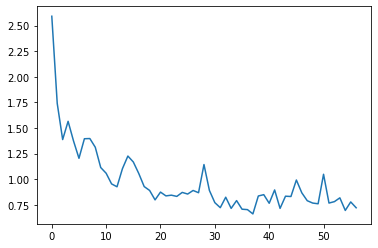

In [591]:
plt.plot(errors)
plt.show()

## Merging Models

In [19]:
indices = np.array([np.arange(0, 512, 16), np.arange(16, 513, 16)]).T
#indices = np.array([np.arange(0, 1024, 16), np.arange(16, 1025, 16)]).T

class ArtSAGENet(nn.Module):
    def __init__(self, n_classes, graph_output_dim, graphnet, resnet):
        super(ArtSAGENet, self).__init__()
        self.graph_output_dim = graph_output_dim
        self.n_classes = n_classes
        self.graphnet = graphnet
        self.resnet = resnet
        
        self.linear_layer = nn.Linear(in_features=2048 + graph_output_dim, out_features=n_classes)
        
    def forward(self, batch_ind, imgs):
        print('------------------fitting graph------------------')
        self.semantic_features = self.graphnet(batch_ind).float()
        #self.visual_features = self.resnet(imgs).float()
        print('------------------fitting resnet------------------')
        self.visual_features = torch.cat([self.resnet(imgs[i:j].to(device)) for i, j in indices]).float()
        self.final_representation = torch.cat([self.visual_features.squeeze(), self.semantic_features], dim=1).float()
        output = self.linear_layer(self.final_representation)
        
        return output    

# model for artist classification

### data

In [121]:
artist_targets = dict(zip(data['artist_attribution'].unique(), range(23)))
data['target_artist'] = data['artist_attribution'].apply(lambda x: artist_targets[x])

In [96]:
data_test['target_artist'] = data_test['artist_attribution'].apply(lambda x: artist_targets[x])

In [123]:
valid_paths=data['relative_path'].values

train_dataset = FinalDataSet(valid_paths, features, data['target_artist'])

In [124]:
#here using smaller batch (512 instead of 1024) since embedding dimension gets really big and requires a lot of space
train_set_artist, val_set_artist = torch.utils.data.random_split(train_dataset, [len(train_dataset) - 512, 512])

train_loader_artist = torch.utils.data.DataLoader(train_set_artist, batch_size = 512, shuffle = True)

val_loader_artist =  torch.utils.data.DataLoader(val_set_artist, batch_size = 512, shuffle = True)

In [99]:
valid_paths =data_test['relative_path']

test_dataset_artist = FinalDataSet(valid_paths, features_test, data_test['target_artist'])
test_loader_artist = torch.utils.data.DataLoader(test_dataset_artist, batch_size = 512, shuffle = True)

### model

In [26]:
# hyperparams for graph representation learning
k1 = 25
k2 = 10
batch_size = 512
gnn_output_len = 200

n_nodes, n_features = features.shape

In [27]:
embed_artist = nn.Embedding(n_nodes, n_features).to(device)
embed_artist.weight = nn.Parameter(torch.FloatTensor(features.values).to(device), requires_grad=True).to(device)

In [28]:
aggregator_artist = MeanAggregation(embed_artist.to(device)).to(device)
get_embed_artist = GetEmbedding(embed_artist.to(device), n_features, batch_size, knowledge_graph.to(device), aggregator_artist.to(device), k1).to(device)

In [29]:
aggregator2_artist = MeanAggregation(lambda embed: get_embed_artist(embed).t().to(device))
get_embed2_artist = GetEmbedding(lambda embed: get_embed_artist(embed).t().to(device), get_embed_artist.batch_len, batch_size, knowledge_graph.to(device), aggregator2_artist.to(device), k2)

In [30]:
gcn_network_artist = GraphNet(gnn_output_len, 23, get_embed2_artist).to(device)

In [31]:
resnet_artist = resnet_initialize(23)

visual_model_artist = torch.nn.Sequential(*list(resnet_artist.children())[:-1])

In [32]:
artists_clf = ArtSAGENet(23, gnn_output_len, gcn_network_artist, visual_model_artist).to(device)

In [34]:
optimizer = torch.optim.SGD(artists_clf.parameters(), lr = 0.005, momentum=0.9) #CHECK LR
criterion = nn.CrossEntropyLoss()

In [125]:
num_epoch = 50
errors_artist = errors_artist

val_errors_artist = val_errors_artist
count_of_same_loss = 0
max_count_of_same_loss = 4
epsilon = 0.005

for epoch in range(0, num_epoch):
    if count_of_same_loss >= max_count_of_same_loss:
        break
        
    artists_clf.train()
    for num_batch, (batch_ind, imgs, semantic_features, labels) in enumerate(train_loader_artist):
        batch_ind = batch_ind.to(device)
        imgs = imgs.to(device)
        semantic_features = semantic_features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        pred = artists_clf(batch_ind, imgs)
        
        loss = criterion(pred, labels)
        errors_artist.append(round(loss.item(), 3))
        
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        
        print('batch number: ', num_batch, "loss: ", errors_artist[-1])
    
    artists_clf.eval()
    for _, (batch_ind, imgs, semantic_features, labels) in enumerate(val_loader_artist):
        batch_ind = batch_ind.to(device)
        imgs = imgs.to(device)
        semantic_features = semantic_features.to(device)
        labels = labels.to(device)
        val_pred = artists_clf(batch_ind, imgs)
        val_loss = criterion(val_pred, labels)
        if np.linalg.norm(val_loss.item() - val_errors_artist[-1]) <= epsilon:
            count_of_same_loss += 1
        else:
            count_of_same_loss = 0
        val_errors_artist.append(val_loss.item())
        print("################################")
        print('epoch: ', epoch, '  validation loss:', round(val_loss.item(), 3))
        print("################################")

------------------fitting graph------------------
------------------fitting resnet------------------
batch number:  0 loss:  0.226


KeyboardInterrupt: 

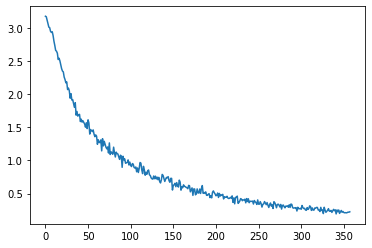

In [178]:
plt.plot(errors_artist[1:])

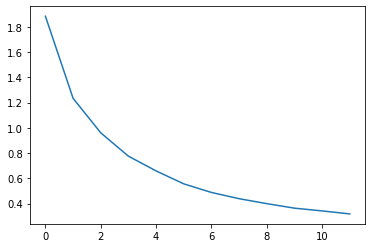

In [37]:
plt.plot(val_errors_artist[1:])

In [40]:
softmax = nn.Softmax(dim=1)

In [126]:
sum(softmax(pred).argmax(1) == labels) / 512

tensor(0.9355, device='cuda:0')

### Visualization

In [127]:
gcn_network_artist.eval();
visual_model_artist.eval();

graph_part_artist = gcn_network_artist(batch_ind)
vis_part_artist = visual_model_artist(imgs)

res_representation_artist = torch.cat([vis_part_artist.cpu().detach().squeeze(), graph_part_artist.cpu().detach()], dim=1)

In [128]:
pca = PCA(n_components=2)
pca_test = pca.fit_transform(torch.cat([semantic_features, imgs.mean(1).mean(1)], dim=1).cpu().detach().numpy())

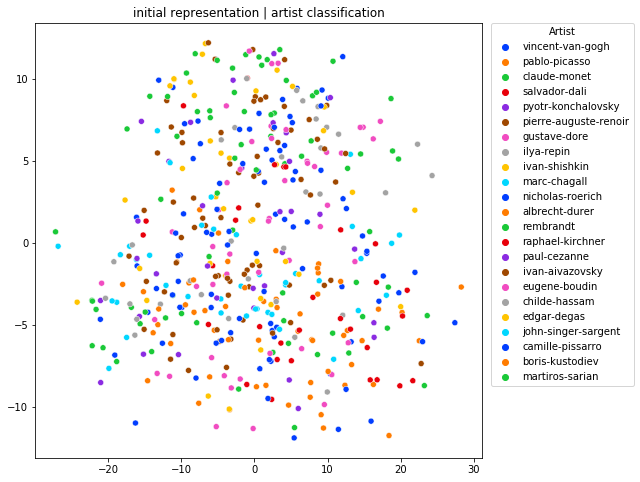

In [163]:
plt.figure(figsize=(8,8))
sns.scatterplot(
    x=pca_test[:,0], y=pca_test[:,1],
    hue=true_artists,
    palette = sns.color_palette("bright", 23),
    legend="full",
    alpha=1
)
plt.title('initial representation | artist classification')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Artist')
plt.show()

In [132]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(res_representation_artist.numpy())

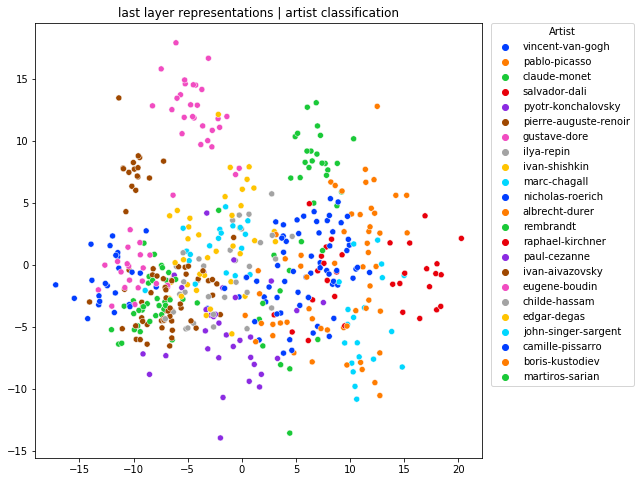

In [162]:
plt.figure(figsize=(8,8))
sns.scatterplot(
    x=pca_result[:,0], y=pca_result[:,1],
    hue=true_artists,
    palette = sns.color_palette("bright", 23),
    legend="full",
    alpha=1
)
plt.title('last layer representations | artist classification')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Artist')
plt.show()

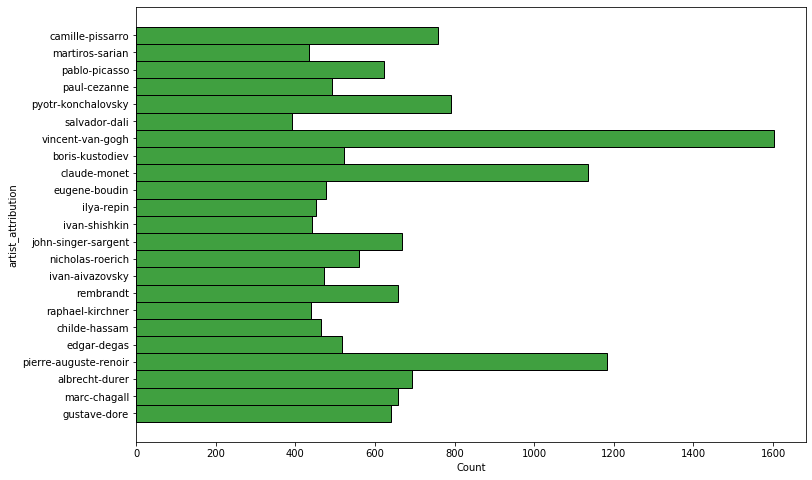

In [177]:
plt.figure(figsize=(12,8))
sns.histplot(y = data['artist_attribution'], color='green')
plt.show()

In [138]:
pca_test1 = PCA(n_components=3)
pca_result_test1 = pca_test1.fit_transform(softmax(pred).cpu().detach().numpy())

In [156]:
decode_artists = {val: key for key, val in artist_targets.items()}

In [158]:
true_artists = [decode_artists[i] for i in labels.cpu().numpy()]

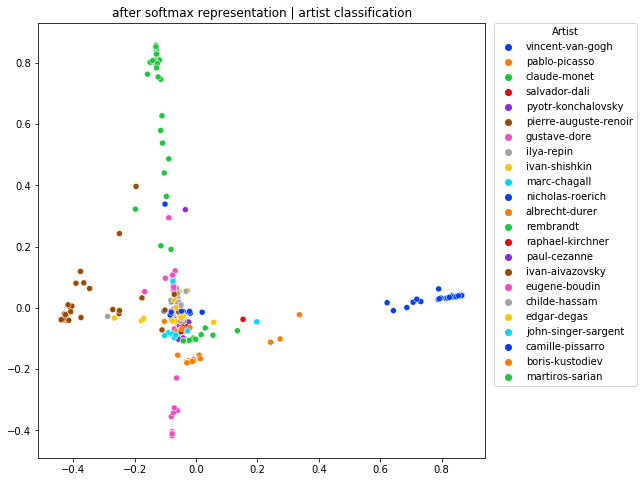

In [159]:
plt.figure(figsize=(8,8))
sns.scatterplot(
    x=pca_result_test1[:,0], y=pca_result_test1[:,2],
    hue=true_artists,
    palette = sns.color_palette("bright", 23),
    legend="full",
    alpha=1
)
plt.title('after softmax representation | artist classification')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Artist')
plt.show()

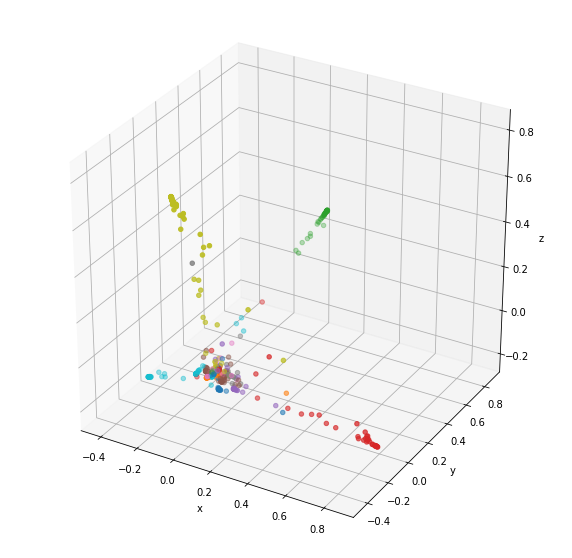

In [186]:
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure(figsize=(10,10)).gca(projection='3d')
ax.scatter(
    ys=pca_result_test1[:,0], 
    zs=pca_result_test1[:,1], 
    xs=pca_result_test1[:,2], 
    c=labels.cpu().numpy(), 
    cmap='tab10'
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

# model for style classification

### data

In [32]:
style_targets = dict(zip(data['style_classification'].unique(), range(12)))
data['target_style'] = data['style_classification'].apply(lambda x: style_targets[x])

In [34]:
valid_paths =data['relative_path'].values

train_dataset = FinalDataSet(valid_paths, features, data['target_style'])

In [35]:
train_set_style, val_set_style = torch.utils.data.random_split(train_dataset, [len(train_dataset) - 1024, 1024])

train_loader_style = torch.utils.data.DataLoader(train_set_style, batch_size = 1024, shuffle = True)

val_loader_style =  torch.utils.data.DataLoader(val_set_style, batch_size = 1024, shuffle = True)

### model parameters

In [22]:
# hyperparams for graph representation learning
k1 = 25
k2 = 10
batch_size = 1024
gnn_output_len = 200

n_nodes, n_features = features.shape

In [23]:
embed_style = nn.Embedding(n_nodes, n_features).to(device)
embed_style.weight = nn.Parameter(torch.FloatTensor(features.values).to(device), requires_grad=True).to(device)

In [24]:
aggregator_style = MeanAggregation(embed_style.to(device)).to(device)
get_embed_style = GetEmbedding(embed_style.to(device), n_features, batch_size, knowledge_graph.to(device), aggregator_style.to(device), k1).to(device)

In [25]:
aggregator2_style = MeanAggregation(lambda embed: get_embed_style(embed).t().to(device))
get_embed2_style = GetEmbedding(lambda embed: get_embed_style(embed).t().to(device), get_embed_style.batch_len, batch_size, knowledge_graph.to(device), aggregator2_style.to(device), k2)

In [26]:
gcn_network_style = GraphNet(gnn_output_len, 12, get_embed2_style).to(device)

In [27]:
resnet_style = resnet_initialize(12)

visual_model_style = torch.nn.Sequential(*list(resnet_style.children())[:-1])

In [28]:
style_clf = ArtSAGENet(12,gnn_output_len, gcn_network_style, visual_model_style).to(device)

In [29]:
style_clf.load_state_dict(torch.load("style_model_clf.pt"))
style_clf.eval();

In [40]:
optimizer = torch.optim.SGD(style_clf.parameters(), lr = 0.001, momentum=0.9) #CHECK LR
criterion = nn.CrossEntropyLoss()

In [45]:
gcn_network_style.train();
get_embed2_style.train();
aggregator2_style.train();
get_embed_style.train();
aggregator_style.train();
visual_model_style.train();

In [49]:
num_epoch = 50
errors_style =[1]

val_errors_style = [1]
count_of_same_loss = 0
max_count_of_same_loss = 4
epsilon = 0.005

for epoch in range(28, num_epoch):
    if count_of_same_loss >= max_count_of_same_loss:
        break
        
    style_clf.train()
    for num_batch, (batch_ind, imgs, semantic_features, labels) in enumerate(train_loader_style):
        batch_ind = batch_ind.to(device)
        imgs = imgs.to(device)
        semantic_features = semantic_features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        pred = style_clf(batch_ind, imgs)
        
        loss = criterion(pred, labels)
        errors_style.append(round(loss.item(), 3))
        
        loss.backward()
        optimizer.step()
        
        print('batch number: ', num_batch, "loss: ", errors_style[-1])
    
    style_clf.eval()
    for _, (batch_ind, imgs, semantic_features, labels) in enumerate(val_loader_style):
        batch_ind = batch_ind.to(device)
        imgs = imgs.to(device)
        semantic_features = semantic_features.to(device)
        labels = labels.to(device)
        val_pred = style_clf(batch_ind, imgs)
        val_loss = criterion(val_pred, labels)
        if np.linalg.norm(val_loss.item() - val_errors_style[-1]) <= epsilon:
            count_of_same_loss += 1
        else:
            count_of_same_loss = 0
        val_errors_style.append(val_loss.item())
        print("################################")
        print('epoch: ', epoch, '  validation loss:', round(val_loss.item(), 3))
        print("################################")

------------------fitting graph------------------
------------------fitting resnet------------------
batch number:  0 loss:  0.845
------------------fitting graph------------------
------------------fitting resnet------------------
batch number:  1 loss:  0.845
------------------fitting graph------------------
------------------fitting resnet------------------
batch number:  2 loss:  0.884
------------------fitting graph------------------
------------------fitting resnet------------------
batch number:  3 loss:  0.9
------------------fitting graph------------------
------------------fitting resnet------------------
batch number:  4 loss:  0.899
------------------fitting graph------------------
------------------fitting resnet------------------
batch number:  5 loss:  0.888
------------------fitting graph------------------
------------------fitting resnet------------------
batch number:  6 loss:  0.84
------------------fitting graph------------------
------------------fitting resnet----

KeyboardInterrupt: 

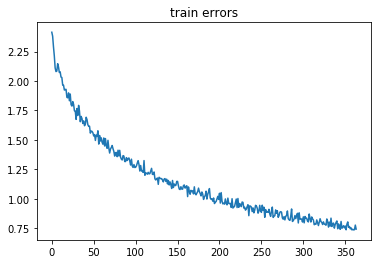

In [200]:
plt.plot(errors_style[1:])
plt.title('train errors')
plt.show()

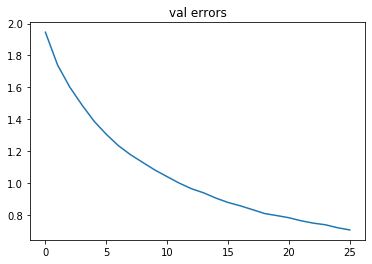

In [201]:
plt.plot(val_errors_style[1:])
plt.title('val errors')
plt.show()

In [36]:
valid_paths_test =data_test['relative_path'].values
test_dataset_style = FinalDataSet(valid_paths_test, features_test, data_test['target_style'])
test_loader_style = torch.utils.data.DataLoader(test_dataset_style, batch_size = 1024, shuffle = True)

In [37]:
style_clf.to(device);

In [38]:
style_clf.eval();
for _, (batch_ind, imgs, semantic_features, labels) in enumerate(test_loader_style):
        batch_ind = batch_ind.to(device)
        imgs = imgs.to(device)
        semantic_features = semantic_features.to(device)
        labels = labels.to(device)
        test_pred = style_clf(batch_ind, imgs)

------------------fitting graph------------------
------------------fitting resnet------------------


In [41]:
criterion(test_pred, labels)

tensor(0.8050, device='cuda:0', grad_fn=<NllLossBackward0>)

In [33]:
softmax = nn.Softmax(dim=1)

In [43]:
#accuracy: 

sum(softmax(test_pred).argmax(dim = 1) == labels) /test_pred.shape[0]

tensor(0.7539, device='cuda:0')

### Visualization

In [44]:
gcn_network_style.eval();
visual_model_style.eval();

graph_part_style = gcn_network_style(batch_ind)
vis_part_style = visual_model_style(imgs)

res_representation_style = torch.cat([vis_part_style.cpu().detach().squeeze(), graph_part_style.cpu().detach()], dim=1)

In [45]:
pca = PCA(n_components=2)
pca_test = pca.fit_transform(torch.cat([semantic_features, imgs.mean(1).mean(1)], dim=1).cpu().detach().numpy())

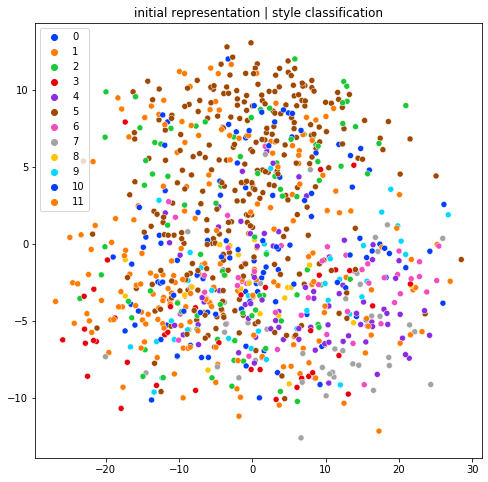

In [46]:
plt.figure(figsize=(8,8))
sns.scatterplot(
    x=pca_test[:,0], y=pca_test[:,1],
    hue=labels.cpu().numpy(),
    palette = sns.color_palette("bright", 12),
    legend="full",
    alpha=1
)
plt.title('initial representation | style classification')
plt.show()

In [47]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(res_representation_style.numpy())

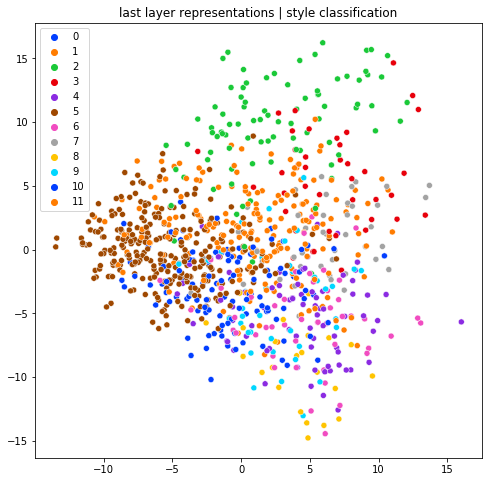

In [48]:
plt.figure(figsize=(8,8))
sns.scatterplot(
    x=pca_result[:,0], y=pca_result[:,1],
    hue=labels.cpu().numpy(),
    palette = sns.color_palette("bright", 12),
    legend="full",
    alpha=1
)
plt.title('last layer representations | style classification')

plt.show()

In [53]:
pca_test1 = PCA(n_components=3)
pca_result_test1 = pca_test1.fit_transform(softmax(test_pred).cpu().detach().numpy())

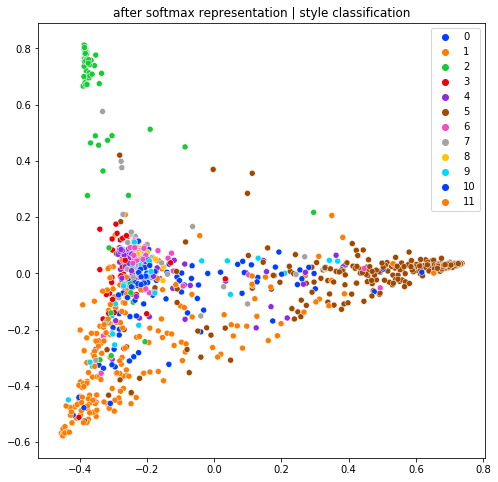

In [52]:
plt.figure(figsize=(8,8))
sns.scatterplot(
    x=pca_result_test1[:,0], y=pca_result_test1[:,1],
    hue=labels.cpu().numpy(),
    palette = sns.color_palette("bright", 12),
    legend="full",
    alpha=1
)
plt.title('after softmax representation | style classification')
plt.show()

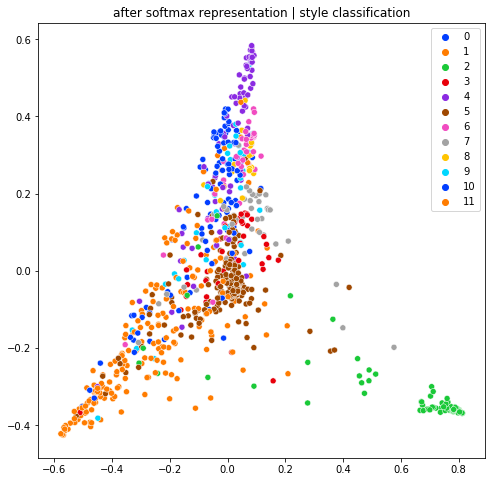

In [55]:
plt.figure(figsize=(8,8))
sns.scatterplot(
    x=pca_result_test1[:,1], y=pca_result_test1[:,2],
    hue=labels.cpu().numpy(),
    palette = sns.color_palette("bright", 12),
    legend="full",
    alpha=1
)
plt.title('after softmax representation | style classification')
plt.show()

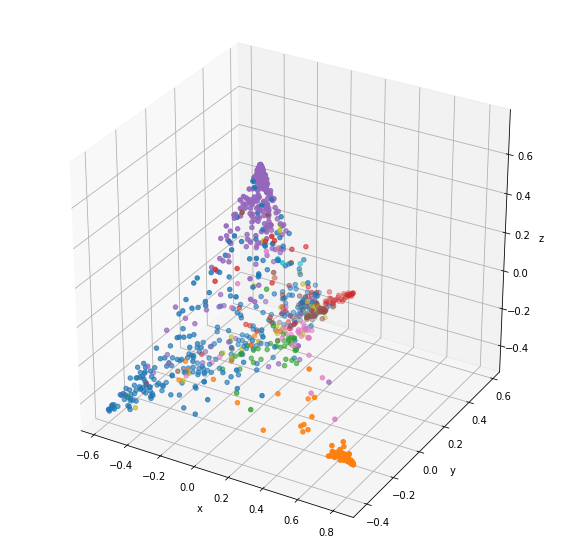

In [77]:
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure(figsize=(10,10)).gca(projection='3d')
ax.scatter(
    zs=pca_result_test1[:,0], 
    xs=pca_result_test1[:,1], 
    ys=pca_result_test1[:,2], 
    c=labels.cpu().numpy(), 
    cmap='tab10'
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()